In [62]:
import numpy as np
import random
import math
from collections import deque

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [63]:
m = 10 # number of locations, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 30 # number of days, ranges from 0 ... d-1
episode_length = 5000
fixed_act_Set = 15
epsilon = 0.99
learning_rate = 0.01
batch_size = 50
gamma = 0.95
epsilon_min = 0
epsilon_decay = 0.9995
#Time to travel from location a to b given bt Time_matrix[a-1, b-1]
Time_matrix = np.random.randint(1, 11,(m, m))
#action is a tuple i,j . 0,0 represents the no ride action
actions = []
for i in range(m):
    for j in range(m):
        if i!=j or i==0:
            actions.append([i,j])
#state is a tuple of location, time, day
states = []
for i in range(m):
    for j in range(t):
        for k in range(d):
            states.append([i,j,k])

In [64]:
#function for encoding the representation of a state and an action
#a state is represented as a vector os size m+t+d, where 1 of first m bits is on for denoting the location and so on
#action is represented as a vector of size 2m. one bit in the first half and in the second half are turned on to
#represent the tuple i,j
def state_trans(state,action,m,t,d):
    state_encod = np.zeros(m+t+d+m+m)
    state_encod.reshape(1,84)
    state_encod[current_state[0]] = 1
    state_encod[m+current_state[1]] = 1
    state_encod[m+t+current_state[2]] = 1
    state_encod[m+t+d+action[0]] = 1
    state_encod[m+t+d+m+action[1]] = 1
    return state_encod   

In [65]:
#select an epsilon-greedy action accoording to q-values
def act(Q_value,epsilon,actions):
    if np.random.rand() <= epsilon:
        index = np.random.randint(0, len(actions),(1, 1))
        if actions[np.int(index)][0] == actions[np.int(index)][1] and actions[np.int(index)][1] != 0:
            return act(Q_value,epsilon,actions)
        else:
            return index
    else:
        index = np.argmax(Q_value)
        if actions[np.int(index)][0] == actions[np.int(index)][1] and actions[np.int(index)][1] != 0:
            return act(Q_value,epsilon,actions)
        else:
            return index

In [66]:
#reward_func for taking action a in state s
def reward_func(state, action, time_matrix):
    start_loc, time, day = state
    pickup, drop = action
    if pickup == 0 and drop == 0:
        return -1
    else:
        return time_matrix[pickup, drop] - time_matrix[start_loc, pickup]

In [67]:
#return the next state, given the current state and action
def next_state_func(state, action, time_matrix, t, d):
    start_loc, time, day = state
    pickup, drop = action
    if pickup == 0 and drop == 0:
        time_elapsed = 1
        drop = start_loc
    else:
        time_elapsed = time_matrix[start_loc, pickup] + time_matrix[pickup, drop]
    time_next = (time + time_elapsed) % t
    day_next = (day + (time + time_elapsed)//t) % d
    return drop, time_next, day_next

In [68]:
#use deep learning model to predict the Q-values for state and set of actions
def prediction_DQN(m,t,d,actions,X):
    state_pred = X[0:m+t+d]
    X_test = np.zeros((len(actions), t+d+3*m))
    for i in range(len(actions)):
        action_encod_p = np.zeros(m+m)
        action_encod_p[actions[i][0]] = 1
        action_encod_p[m + actions[i][1]] = 1
        dummy = np.hstack((state_pred,action_encod_p))
        X_test[i,:] = dummy
    prediction = model.predict(X_test)
    prediction = prediction.reshape(len(actions))
    return prediction

In [69]:
# Deep learning model
model = Sequential()
model.add(Dense(100, input_dim = np.int(m+t+d+m+m),activation ='relu'))
model.add(Dense(100,activation ='relu'))
model.add(Dense(1,activation ='linear'))
model.compile(loss='mse',optimizer=Adam(lr=learning_rate))

Reward:-5,Episode:0, Epsilon:0.99
Reward:6,Episode:50, Epsilon:0.9895050000000001
Reward:0,Episode:100, Epsilon:0.965068000796419
Reward:-3,Episode:150, Epsilon:0.941234502262441
Reward:-3,Episode:200, Epsilon:0.9179896002334768
Reward:8,Episode:250, Epsilon:0.895318758620952
Reward:6,Episode:300, Epsilon:0.8732078003222356
Reward:-2,Episode:350, Epsilon:0.8516428983550544
Reward:3,Episode:400, Epsilon:0.8306105672108581
Reward:5,Episode:450, Epsilon:0.8100976544217183
Reward:-6,Episode:500, Epsilon:0.7900913323354967
Reward:5,Episode:550, Epsilon:0.7705790900941347
Reward:1,Episode:600, Epsilon:0.7515487258100461
Reward:3,Episode:650, Epsilon:0.7329883389357275
Reward:2,Episode:700, Epsilon:0.7148863228218055
Reward:5,Episode:750, Epsilon:0.697231357458874
Reward:1,Episode:800, Epsilon:0.6800124023985821
Reward:8,Episode:850, Epsilon:0.663218689849541
Reward:4,Episode:900, Epsilon:0.6468397179437362
Reward:4,Episode:950, Epsilon:0.6308652441692371
Reward:5,Episode:1000, Epsilon:0.6152

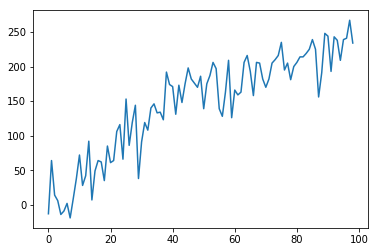

In [71]:
# code for genrating episode
memory = deque(maxlen=2000)
current_state =  (np.random.randint(0, m),np.random.randint(0, t),np.random.randint(0, d))
count  =  0
rewards = []
tot_reward = 0
for epi_len in range(episode_length):
    # pick a random action
    if epi_len % 50 == 0 and epi_len != 0:
        rewards.append(tot_reward)
        tot_reward = 0
    count = count + 1
    index_State = states.index([current_state[0],current_state[1],current_state[2]])
    X = state_trans(current_state,[0,0],m,t,d)
    #randomly sample some r no of actions from the action set
    r = np.random.randint(m*m/20, m*m/9)
    poss_actions = np.random.randint(0, (m-1)*m + 1, r)
    poss_actions = [actions[i] for i in poss_actions]
    #get the next action according to epsilon-greedy policy
    action = poss_actions[np.int(act(prediction_DQN(m,t,d,poss_actions,X),epsilon,poss_actions))]
    #obtain the reward by performing the action
    reward = reward_func(current_state, action, Time_matrix)
    tot_reward += reward
    #obtain the next state
    next_state = next_state_func(current_state, action, Time_matrix, t, d)
    X = state_trans(current_state,action,m,t,d)
    #print("State: ",current_state, " Action: ", action, " Reward: ", reward, " Nextstate: ", next_state)
    index_Next_State = states.index([next_state[0],next_state[1],next_state[2]])
    #append curr_state, action, reward, next_state to memory replay buffer
    memory.append((X,reward,index_Next_State))
    current_state = next_state
    if count > batch_size:
        mini_batch = random.sample(memory, batch_size)
        target_mini_batch = np.zeros((batch_size, 1))
        input_mini_batch = np.zeros((batch_size, t+d+3*m))
        #update the model according to randomly sampled batch from replay memory
        for i in range(batch_size):
            X, reward, index_Next_state = mini_batch[i]
            X_next = state_trans(index_Next_state,[0,0],m,t,d)
            #get the target for the Q-network
            target = reward + gamma*np.amax(prediction_DQN(m,t,d,actions,X_next))
            input_mini_batch[i, :] = X
            target_mini_batch[i, :] = target
        model.fit(input_mini_batch,target_mini_batch, epochs = 1, verbose = 0)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
    if epi_len % 50 == 0:
        print("Reward:{},Episode:{}, Epsilon:{}".format(reward,epi_len,epsilon))
plt.plot(list(range(len(rewards))), rewards)
plt.show()

In [11]:
x= [2, 3, 4, 5]
y = [0, 1]
x[y]

TypeError: list indices must be integers or slices, not list